In [13]:
import torch
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

In [14]:
class aerialBuildingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and text. Of the form ./data/genTrain etc...
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.maps = os.listdir(root_dir) #These are all the maps in the root. austin10 chicago55 etc...
        self.root_dir = root_dir 
        self.transform = transform 

        #Retrieve all the image locations with their coordinates
        self.imageList = [] #List of images e.g ./data/genTrain/austin10/860.png
        self.cornerList = [] #Get all the image paths in our dataset
        for map in self.maps:
            images = [x for x in os.listdir(os.path.join(root_dir,map)) if re.search("png",x)]
            coordinates = [x for x in os.listdir(os.path.join(root_dir,map)) if re.search("txt",x)]
            for image in images:
                number = image.split('.png')[0]
                corner = [x for x in coordinates if re.search('^'+number+'.txt',x)][0]
                if len(corner) == 0:
                    break
                self.cornerList.append(os.path.join(root_dir, map,corner))
                self.imageList.append(os.path.join(root_dir, map,image))
        if (len(self.imageList) != len(self.cornerList)):
            raise ValueError('Oops, mismatch in images and coordinate files')
        
    def __len__(self):
        return len(self.imageList)

    def __getitem__(self, idx):
        img_file = os.path.join(self.imageList[idx])
        image = io.imread(img_file)
        corner_file = self.cornerList[idx]
        with open(corner_file) as f:
            content = f.readlines()
            content = np.array([x.strip().split(' ') for x in content])
        sample = {'image': image, 'corners': content}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [15]:
#helper function to show building and its corners.
def show_landmarks(image, corners):
    plt.figure(figsize=(4,4))
    """Show image with landmarks"""
    plt.imshow(image)
    print(corners)
    plt.scatter(corners[:, 0], corners[:, 1], s=10, marker='.', c='r')
    plt.show()

In [16]:
#Load the dataset
building_dataset = aerialBuildingDataset(root_dir='./data/genTrain')

(288, 288, 4) (4, 2)
[['29' '20']
 ['20' '37']
 ['39' '48']
 ['48' '31']]


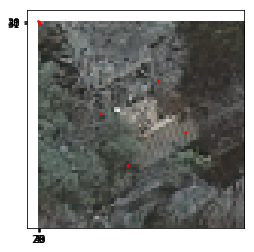

In [17]:
sample = building_dataset[552]
print(sample['image'].shape, sample['corners'].shape)
show_landmarks(**sample)

For each input image, VGG-16 is used without tail layers as the backbone to extract a set of "skip features" 1/8 the size of input images. Then this goes through conv layers to obtain a heat-map mask of boundaries. This is then convolved to output a mask of candidate keypoints (V). Both B and V have size 1/8 the original image

In [22]:
class SamePad2d(nn.Module):
    """Mimics tensorflow's 'SAME' padding.
    """

    def __init__(self, kernel_size, stride):
        super(SamePad2d, self).__init__()
        self.kernel_size = torch.nn.modules.utils._pair(kernel_size)
        self.stride = torch.nn.modules.utils._pair(stride)

    def forward(self, input):
        in_width = input.size()[2]
        in_height = input.size()[3]
        out_width = math.ceil(float(in_width) / float(self.stride[0]))
        out_height = math.ceil(float(in_height) / float(self.stride[1]))
        pad_along_width = ((out_width - 1) * self.stride[0] +
                           self.kernel_size[0] - in_width)
        pad_along_height = ((out_height - 1) * self.stride[1] +
                            self.kernel_size[1] - in_height)
        pad_left = math.floor(pad_along_width / 2)
        pad_top = math.floor(pad_along_height / 2)
        pad_right = pad_along_width - pad_left
        pad_bottom = pad_along_height - pad_top
        return F.pad(input, (pad_left, pad_right, pad_top, pad_bottom), 'constant', 0)

    def __repr__(self):
        return self.__class__.__name__

In [27]:
#Network consisting of the skipfeature convolutions for generating 1/8 mask of candidate keypoints.

class Mask(nn.Module):
    def __init__(self, depth, pool_size, image_shape):
        super(Mask, self).__init__()
        self.depth = depth
        self.pool_size = pool_size
        self.image_shape = image_shape
        self.num_classes = 2
        self.padding = SamePad2d(kernel_size=3, stride=1)
        self.conv1 = nn.Conv2d(self.depth, 256, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(256, eps=0.001)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(256, eps=0.001)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(256, eps=0.001)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256, eps=0.001)
        self.deconv = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(256, self.num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, rois):
#  We input individual buildings
#         x = pyramid_roi_align([rois] + x, self.pool_size, self.image_shape)
        x = self.conv1(self.padding(x))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(self.padding(x))
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(self.padding(x))
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(self.padding(x))
        x = self.bn4(x)
        x = self.relu(x)
        x = self.deconv(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.sigmoid(x)

        return x

In [28]:
# #VGG net simplified.

# class VGG1(nn.Module):
#     def __init__(self, depth, pool_size, image_shape)

In [31]:
class GeoNet(nn.Module):
    def __init__(self, model_dir):
        """
        config: A Sub-class of the Config class
        model_dir: Directory to save training logs and trained weights
        """
        super(GeoNet, self).__init__()
        self.MASK_POOL_SIZE = 256
        self.IMAGE_SHAPE = 256
        self.model_dir = model_dir
        self.build()
        self.initialize_weights()
    
    def build(self):
        """Build GeoNet architecture.
        """
#         Todo: Replace simple convolution of input to skip feature input.
#         self.backbone = Backbone(3)
        self.mask = Mask(256, self.MASK_POOL_SIZE, self.IMAGE_SHAPE)


    def initialize_weights(self):
        """Initialize model weights.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def predict(self, input, mode):
        molded_images = input[0]
        image_metas = input[1]

        if mode == 'inference':
            self.eval()
        elif mode == 'training':
            self.train()

            # Set batchnorm always in eval mode during training
            def set_bn_eval(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()

            self.apply(set_bn_eval)

        # Feature extraction
        [p2_out, p3_out, p4_out, p5_out, p6_out] = self.fpn(molded_images)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [p2_out, p3_out, p4_out, p5_out, p6_out]
        mrcnn_feature_maps = [p2_out, p3_out, p4_out, p5_out]

        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(self.rpn(p))

        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        outputs = list(zip(*layer_outputs))
        outputs = [torch.cat(list(o), dim=1) for o in outputs]
        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = self.config.POST_NMS_ROIS_TRAINING if mode == "training" \
            else self.config.POST_NMS_ROIS_INFERENCE
        rpn_rois = proposal_layer([rpn_class, rpn_bbox],
                                 proposal_count=proposal_count,
                                 nms_threshold=self.config.RPN_NMS_THRESHOLD,
                                 anchors=self.anchors,
                                 config=self.config)

        if mode == 'inference':
            # Network Heads
            # Proposal classifier and BBox regressor heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox = self.classifier(mrcnn_feature_maps, rpn_rois)

            # Detections
            # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in image coordinates
            detections = detection_layer(self.config, rpn_rois, mrcnn_class, mrcnn_bbox, image_metas)

            # Convert boxes to normalized coordinates
            # TODO: let DetectionLayer return normalized coordinates to avoid
            #       unnecessary conversions
            h, w = self.config.IMAGE_SHAPE[:2]
            scale = Variable(torch.from_numpy(np.array([h, w, h, w])).float(), requires_grad=False)
            if self.config.GPU_COUNT:
                scale = scale.cuda()
            detection_boxes = detections[:, :4] / scale

            # Add back batch dimension
            detection_boxes = detection_boxes.unsqueeze(0)

            # Create masks for detections
            mrcnn_mask = self.mask(mrcnn_feature_maps, detection_boxes)

            # Add back batch dimension
            detections = detections.unsqueeze(0)
            mrcnn_mask = mrcnn_mask.unsqueeze(0)

            return [detections, mrcnn_mask]

        elif mode == 'training':

            gt_class_ids = input[2]
            gt_boxes = input[3]
            gt_masks = input[4]

            # Normalize coordinates
            h, w = self.config.IMAGE_SHAPE[:2]
            scale = Variable(torch.from_numpy(np.array([h, w, h, w])).float(), requires_grad=False)
            if self.config.GPU_COUNT:
                scale = scale.cuda()
            gt_boxes = gt_boxes / scale

            # Generate detection targets
            # Subsamples proposals and generates target outputs for training
            # Note that proposal class IDs, gt_boxes, and gt_masks are zero
            # padded. Equally, returned rois and targets are zero padded.
            rois, target_class_ids, target_deltas, target_mask = \
                detection_target_layer(rpn_rois, gt_class_ids, gt_boxes, gt_masks, self.config)

            if not rois.size():
                mrcnn_class_logits = Variable(torch.FloatTensor())
                mrcnn_class = Variable(torch.IntTensor())
                mrcnn_bbox = Variable(torch.FloatTensor())
                mrcnn_mask = Variable(torch.FloatTensor())
                if self.config.GPU_COUNT:
                    mrcnn_class_logits = mrcnn_class_logits.cuda()
                    mrcnn_class = mrcnn_class.cuda()
                    mrcnn_bbox = mrcnn_bbox.cuda()
                    mrcnn_mask = mrcnn_mask.cuda()
            else:
                # Network Heads
                # Proposal classifier and BBox regressor heads
                mrcnn_class_logits, mrcnn_class, mrcnn_bbox = self.classifier(mrcnn_feature_maps, rois)

                # Create masks for detections
                mrcnn_mask = self.mask(mrcnn_feature_maps, rois)

            return [rpn_class_logits, rpn_bbox, target_class_ids, mrcnn_class_logits, target_deltas, mrcnn_bbox, target_mask, mrcnn_mask]

        return results

In [32]:
net = GeoNet('./placeholderDir')

In [34]:
net.state_dict()

OrderedDict([('mask.conv1.weight', tensor([[[[-0.0190,  0.0025,  0.0054],
                        [-0.0227,  0.0118,  0.0090],
                        [-0.0196, -0.0287,  0.0123]],
              
                       [[-0.0214, -0.0264, -0.0275],
                        [ 0.0170, -0.0182, -0.0175],
                        [ 0.0133, -0.0134, -0.0164]],
              
                       [[-0.0014, -0.0332, -0.0220],
                        [ 0.0184,  0.0062,  0.0262],
                        [ 0.0055, -0.0023, -0.0262]],
              
                       ...,
              
                       [[ 0.0336, -0.0022, -0.0208],
                        [-0.0255, -0.0216,  0.0231],
                        [-0.0151, -0.0266, -0.0089]],
              
                       [[ 0.0354, -0.0289, -0.0242],
                        [-0.0037,  0.0347,  0.0219],
                        [ 0.0206, -0.0227,  0.0351]],
              
                       [[-0.0173,  0.0280, -0.0238],
        